# Wisconsin Breast Cancer Database  
*In this notebook we scrape this data, analyze it and make some ML models to predict any data object's class*.

Notebook initialization: libraries import and initialization of the *matplotlib* vizualizer.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

Constants initialization.

In [2]:
URL_TO_DATA = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
DATA_DELIMITER = ","
NA_VALUE = "?"
COLUMNS_NAMES = [
    "Sample code number",
    "Clump Thickness",
    "Uniformity of Cell Size",
    "Uniformity of Cell Shape",
    "Marginal Adhesion",
    "Single Epithelial Cell Size",
    "Bare Nuclei",
    "Bland Chromatin",
    "Normal Nucleoli",
    "Mitoses",
    "Class"
]

Data scrapping from the server.

In [3]:
df = pd.read_csv(
    URL_TO_DATA,
    header=None,
    delimiter=DATA_DELIMITER,
    names=COLUMNS_NAMES,
    index_col=COLUMNS_NAMES[0],
    na_values=NA_VALUE,
    dtype={column: "object" for column in COLUMNS_NAMES[1:]}
)

Printing of the first dataframe's rows.

In [4]:
df.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
Sample code number,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2


Printing of the basic dataframe's statistics (description is about categorical features).

In [5]:
data_describe = df.describe()
data_describe

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,699,699,699,699,699,683,699,699,699,699
unique,10,10,10,10,10,10,10,10,9,2
top,1,1,1,1,2,1,2,1,1,2
freq,145,384,353,407,386,402,166,443,579,458


Replacing of not available data (NA values interpreted in dataframe as *"?"* symbol) to the most frequent values of the features.

In [6]:
for column in COLUMNS_NAMES[1:]:
    top_value = df[column].describe()["top"]
    df[column] = df[column].fillna(top_value)

Reprinting of the dataframe's basic statistics: there are not missing values now.

In [7]:
df.describe()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,699,699,699,699,699,699,699,699,699,699
unique,10,10,10,10,10,10,10,10,9,2
top,1,1,1,1,2,1,2,1,1,2
freq,145,384,353,407,386,418,166,443,579,458


Drawing histograms of all the features in the dataset, saving into the pictures of *.png* format (pictures' directory is located in the same place as current *.ipynb* file).

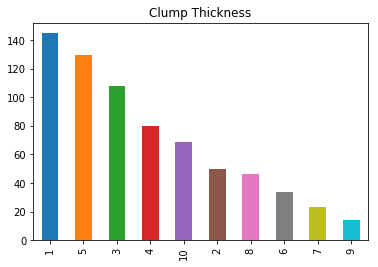

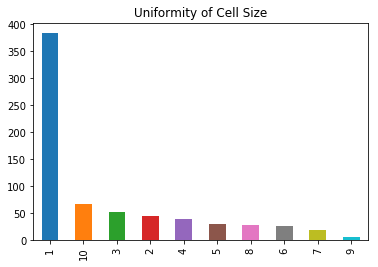

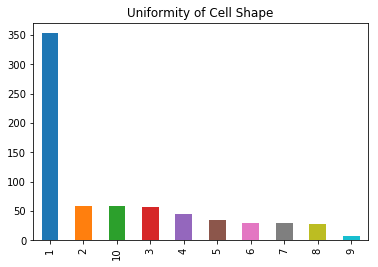

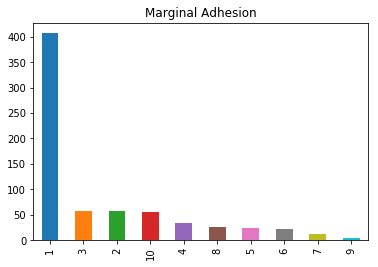

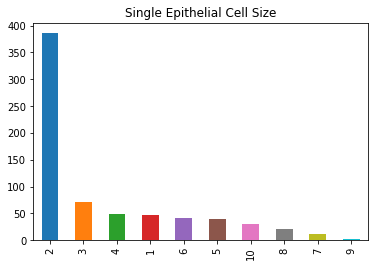

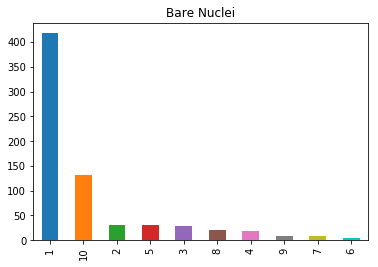

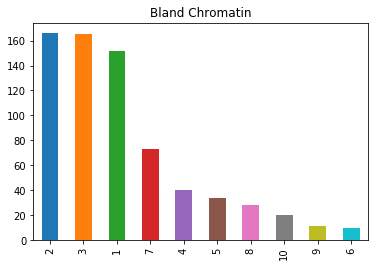

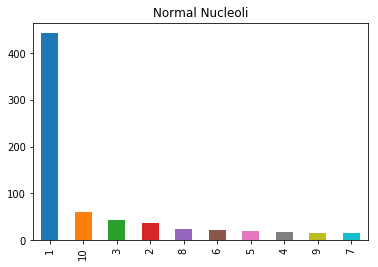

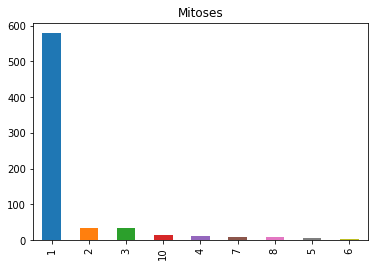

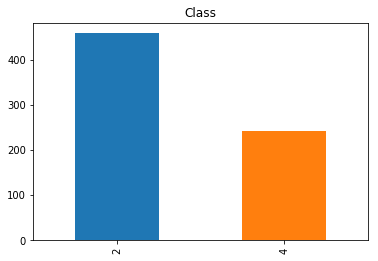

In [8]:
for column in COLUMNS_NAMES[1:]:
    df_plot = df[column].value_counts().plot(kind="bar", title=column)
    plt.show()
    fig = df_plot.get_figure()
    fig.savefig("plots/" + column.lower().replace(" ", "_") + ".png")


Searching for binary and non binary columns' names in the dataset. Printing numbers of the features of each kind (binary, non binary): binary feature is only one - *Class*.

In [9]:
binary_columns = [column for column in COLUMNS_NAMES[1:] if data_describe[column]["unique"] == 2]
nonbinary_columns = [column for column in COLUMNS_NAMES[1:] if data_describe[column]["unique"] > 2]
len(binary_columns), len(nonbinary_columns)

(1, 9)

Replacing of the categorical binary features to the numeric (the most popular feature's value is defined as $1$, another as $0$) using defined function *change_binary*.

In [10]:
def change_binary(data, column_name, top_value):
    for default_value in data[column_name].unique():
        if default_value == top_value:
            data.loc[data[column_name] == default_value, column_name] = 1
        else:
            data.loc[data[column_name] == default_value, column_name] = 0
    return data[column_name]

binary_values = {}
for binary_column in binary_columns:
    binary_column_description = df[binary_column].describe()
    
    binary_values[binary_column] = {}
    binary_values[binary_column]["top"] = binary_column_description["top"]
    
    df[binary_column] = change_binary(
        df,
        binary_column,
        binary_values[binary_column]["top"]
    )

Printing of the binary feature's basic statistics: replacing is successful.

In [11]:
df["Class"].describe()

count     699
unique      2
top         1
freq      458
Name: Class, dtype: int64

Vectorizing categorical non binary features: if we have any feature $f$ containing values $v_1, v_2, \dots, v_n, n \in \mathbb{N}$ then replacing this feature into these ones: $f_{v_1}, f_{v_2}, \dots, f_{v_n}, n \in \mathbb{N}$ where each of the obtained features has only two values: $\{0, 1\}$ mean that the feature is characteristic of the current object or not.

In [12]:
df_nonbinary = pd.get_dummies(df[nonbinary_columns])

In [13]:
df_nonbinary.shape

(699, 89)

Concatenating all the obtained parts of the dataframe into one.

In [14]:
df = pd.concat((df_nonbinary, df[binary_columns]), axis=1)
df = pd.DataFrame(df, dtype="float")

Printing of the information of obtained dataframe: shape (number of rows, number of columns), columns' names (obtained features), columns' types (every of them is numeric - *float64*).

In [15]:
print(df.shape, df.columns, df.dtypes, sep="\n\n")

(699, 90)

Index(['Clump Thickness_1', 'Clump Thickness_10', 'Clump Thickness_2',
       'Clump Thickness_3', 'Clump Thickness_4', 'Clump Thickness_5',
       'Clump Thickness_6', 'Clump Thickness_7', 'Clump Thickness_8',
       'Clump Thickness_9', 'Uniformity of Cell Size_1',
       'Uniformity of Cell Size_10', 'Uniformity of Cell Size_2',
       'Uniformity of Cell Size_3', 'Uniformity of Cell Size_4',
       'Uniformity of Cell Size_5', 'Uniformity of Cell Size_6',
       'Uniformity of Cell Size_7', 'Uniformity of Cell Size_8',
       'Uniformity of Cell Size_9', 'Uniformity of Cell Shape_1',
       'Uniformity of Cell Shape_10', 'Uniformity of Cell Shape_2',
       'Uniformity of Cell Shape_3', 'Uniformity of Cell Shape_4',
       'Uniformity of Cell Shape_5', 'Uniformity of Cell Shape_6',
       'Uniformity of Cell Shape_7', 'Uniformity of Cell Shape_8',
       'Uniformity of Cell Shape_9', 'Marginal Adhesion_1',
       'Marginal Adhesion_10', 'Marginal Adhesion_2', 'Marginal A

Splitting of the dataset into two parts: $70\%$ of data is for algorithm train, another $30\%$ is for tests. *X_train*, *X_test* are defined as all the features except the answer feature (*Class*), *y_train* and *y_test* - the answer feature data.

In [16]:
from sklearn.model_selection import train_test_split
X, y = df.drop((COLUMNS_NAMES[-1]), axis=1), df[COLUMNS_NAMES[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11)

In [17]:
X_train.shape[0], X_test.shape[0]

(489, 210)

Using and training *K nearest neighbors* algorithm (number of the neighbors is equal $5$) of the metric classification paradigm.

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

In [19]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Definition of the errors printing function (percent format). Predict values of the answer feature based on object of traing part of data and of test part of data, get the result error not greater than $\approx 6.7\%$ in the test data.

In [20]:
def show_errors(train_data_error, test_data_error):
    print(
        "Train data error: {0:.3%}".format(train_data_error), 
        "Test data error: {0:.3%}".format(test_data_error) ,
        sep="\n"
    )
y_train_predicted = knn.predict(X_train)
y_test_predicted = knn.predict(X_test)

err_train = np.mean(y_train != y_train_predicted)
err_test = np.mean(y_test  != y_test_predicted)

show_errors(err_train, err_test)

Train data error: 4.294%
Test data error: 6.667%


Using grid optimal *K nearest neighbors* algorythm parameters (*n_neighbors*) search algorythm: GridSearchCV (grid search cross validation). The best error result of all the parameter values (closed integers interval $[1; 19] \setminus \{5\}$) is $\approx 4.5\%$ with *n_neighbors* parameter is equal $4$.

In [21]:
from sklearn.model_selection import GridSearchCV
n_neighbors_list = list(range(1, 20))
n_neighbors_list.remove(5)
n_neighbors_list

[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [22]:
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid={'n_neighbors': n_neighbors_list})
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [23]:
best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
best_cv_err, best_n_neighbors

(0.04498977505112478, 4)

In [24]:
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(X_train, y_train)

err_train = np.mean(y_train != knn.predict(X_train))
err_test = np.mean(y_test != knn.predict(X_test))

show_errors(err_train, err_test)

Train data error: 2.863%
Test data error: 4.762%


Similarly using *support vector machine* algorithm.


In [25]:
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
err_train = np.mean(y_train != svc_model.predict(X_train))
err_test = np.mean(y_test != svc_model.predict(X_test))

show_errors(err_train, err_test)

Train data error: 2.249%
Test data error: 2.857%


In [27]:
c_parameter_array = np.logspace(-3, 3, num=7)
gamma_parameter_array = np.logspace(-5, 2, num=8)

svc_model = SVC(kernel="rbf")

grid = GridSearchCV(
    svc_model,
    param_grid={
        "C": c_parameter_array,
        "gamma": gamma_parameter_array
    }
)
grid.fit(X_train, y_train)

best_svc_error = 1 - grid.best_score_
best_svc_c = grid.best_estimator_.C
best_svc_gamma = grid.best_estimator_.gamma

print("Cross validation error:", best_svc_error * 100, "%")
print("Best C parameter:", best_svc_c)
print("Best gamma parameter:", best_svc_gamma)

Cross validation error: 3.0674846625766916 %
Best C parameter: 1.0
Best gamma parameter: 0.01


In [28]:
svc_model = SVC(
    kernel="rbf",
    C=best_svc_c,
    gamma=best_svc_gamma
)

svc_model.fit(X_train, y_train)

err_train = np.mean(svc_model.predict(X_train) != y_train)
err_test = np.mean(svc_model.predict(X_test) != y_test)

show_errors(err_train, err_test)

Train data error: 2.249%
Test data error: 2.857%


Using *random forest* algorithm of the logic classification paradigm.

In [29]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))

show_errors(err_train, err_test)

Train data error: 0.000%
Test data error: 3.333%
